### Clustering in feature space is already good, but can it be better in latent space?

<div style="font-size: 12px;">

- consider (variational) auto encoder:
    - we have noisy input, but we dont have access to clean signals
        - better use VAE (with Gaussian Prior regularization) than AE
    - AE is better suited for clean signal's representation learning
        - add noise, train model on clean signal, which is impossible for our case here

</div>

<div style="font-size: 10px;">

| Method                                                              | Type                    | Description                                                              | When to Use                                                                                     | Pros                                                                                          | Cons                                                                 |
| ------------------------------------------------------------------- | ----------------------- | ------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------- | -------------------------------------------------------------------- |
| **(1) Clustering PIP Sequences**                                    | Unsupervised            | Group similar market structures (e.g. V-shaped, range-bound)             | You expect *finite recurring patterns* (motifs), possibly useful for classification or labeling | Simple, interpretable (k-means, HDBSCAN, GMM), allows regime detection                        | May struggle if latent patterns are highly non-linear                |
| **(2) Autoencoder (AE) on PIPs**                                    | Representation learning | Compress PIP features to latent space, decode back                       | You expect complex, *nonlinear structure* in PIPs (e.g. curvature, nested trends)               | Powerful latent representations, can visualize latent space, reconstructability is measurable | Needs more data, more tuning; latent space may not cluster naturally |
| **(3) Variational Autoencoder (VAE)**                               | Probabilistic           | Same as AE, but with learned distributional latent space                 | You want to **sample** from learned market structures (e.g. simulation, generative modeling)    | Smooth latent space, better interpolation & clustering                                        | Harder to train and tune, interpretability issues                    |
| **(4) Sequence Models (Transformer/TCN on PIPs)**                   | Sequence modeling       | Model temporal transitions of PIPs directly                              | For modeling *sequential decision making* or temporal dependencies                              | Captures *evolution* of patterns, not just shape                                              | Needs more data, complex training                                    |
| **(5) Contrastive Self-Supervised Learning (e.g., SimCLR, TS-TCC)** | Self-supervised         | Learn representations that cluster similar PIP structures without labels | For robust generalization and downstream supervised tasks                                       | Learns invariance (e.g., to noise, temporal warps), needs no label                            | Requires well-designed augmentations of PIPs                         |
| **(6) Shapelet Transform or SAX + Symbolic Clustering**             | Symbolic                | Convert PIPs to symbolic representation, then cluster patterns           | When you want to **count** or compare shapes like motifs                                        | Compact, interpretable, low memory                                                            | Loses some nuance vs. latent space                                   |


| Feature                                  | Explanation                                                                                                        | Why It’s Unique                                                                                          |
| ---------------------------------------- | ------------------------------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------- |
| **Nonlinear Representation Learning**    | Autoencoders can learn **nonlinear manifolds** via deep networks, unlike PCA which is limited to linear subspaces. | PCA/other linear methods fail when data lies on a nonlinear manifold. AE captures this.                  |
| **Domain-Specific Compression**          | They learn compression tailored to the data distribution, not general-purpose like JPEG.                           | Unlike handcrafted compression, AE is learned end-to-end on task-specific data.                          |
| **Denoising and Robust Features**        | Denoising AEs learn to **reconstruct clean data from noisy input**, thus learning robust features.                 | Classical methods (e.g., Gaussian filter) don’t learn what “noise” is. AE learns noise model implicitly. |
| **Smooth & Interpolatable Latent Space** | Good AEs (especially VAEs) ensure interpolations in latent space yield valid data.                                 | Important for generative tasks, simulation, data augmentation.                                           |
| **Foundation for Generative Modeling**   | Variational AEs bridge **deep learning and probabilistic graphical models**, enabling generative sampling.         | This forms basis of **Bayesian deep learning**, e.g., VAEs, Deep Latent Gaussian Models.                 |
| **Self-supervised Learning Backbone**    | AE-based losses are often used for pretraining or auxiliary tasks in **self-supervised setups**.                   | Works without labels, enabling large-scale pretraining (e.g., SimCLR-style pretext tasks).               |
| **Anomaly Detection**                    | High reconstruction error = anomaly. Simple but effective detection mechanism.                                     | Useful in domains with no labels and rare events (e.g., fraud detection, fault monitoring).              |


</div>

### KDE density of VAE latent space (posterior approx)
- we do see some obvious clusters forming, but are they performant (cleaner features)?
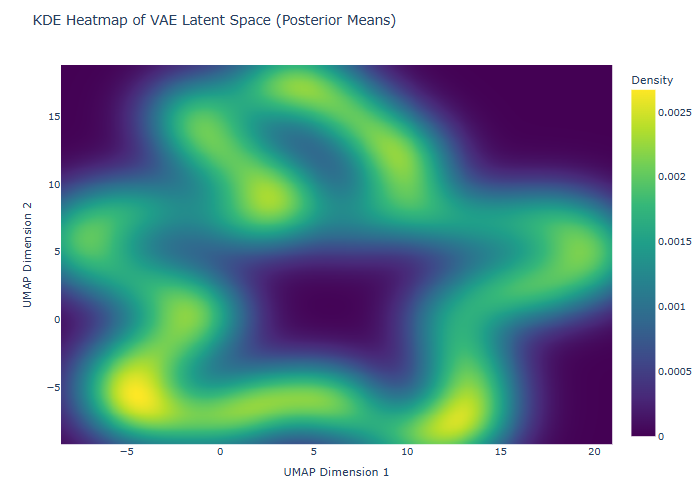
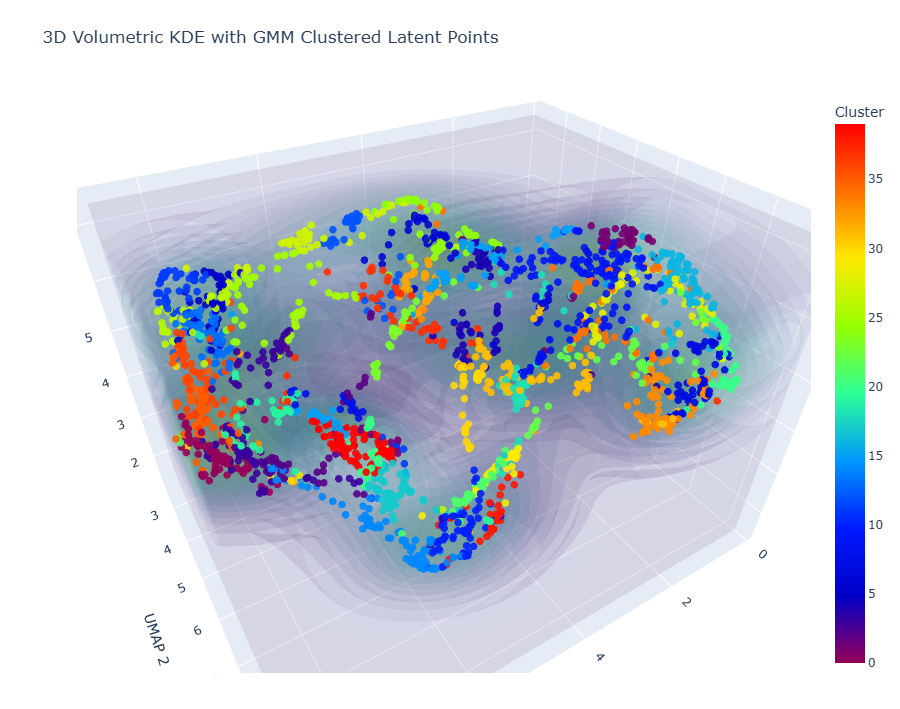

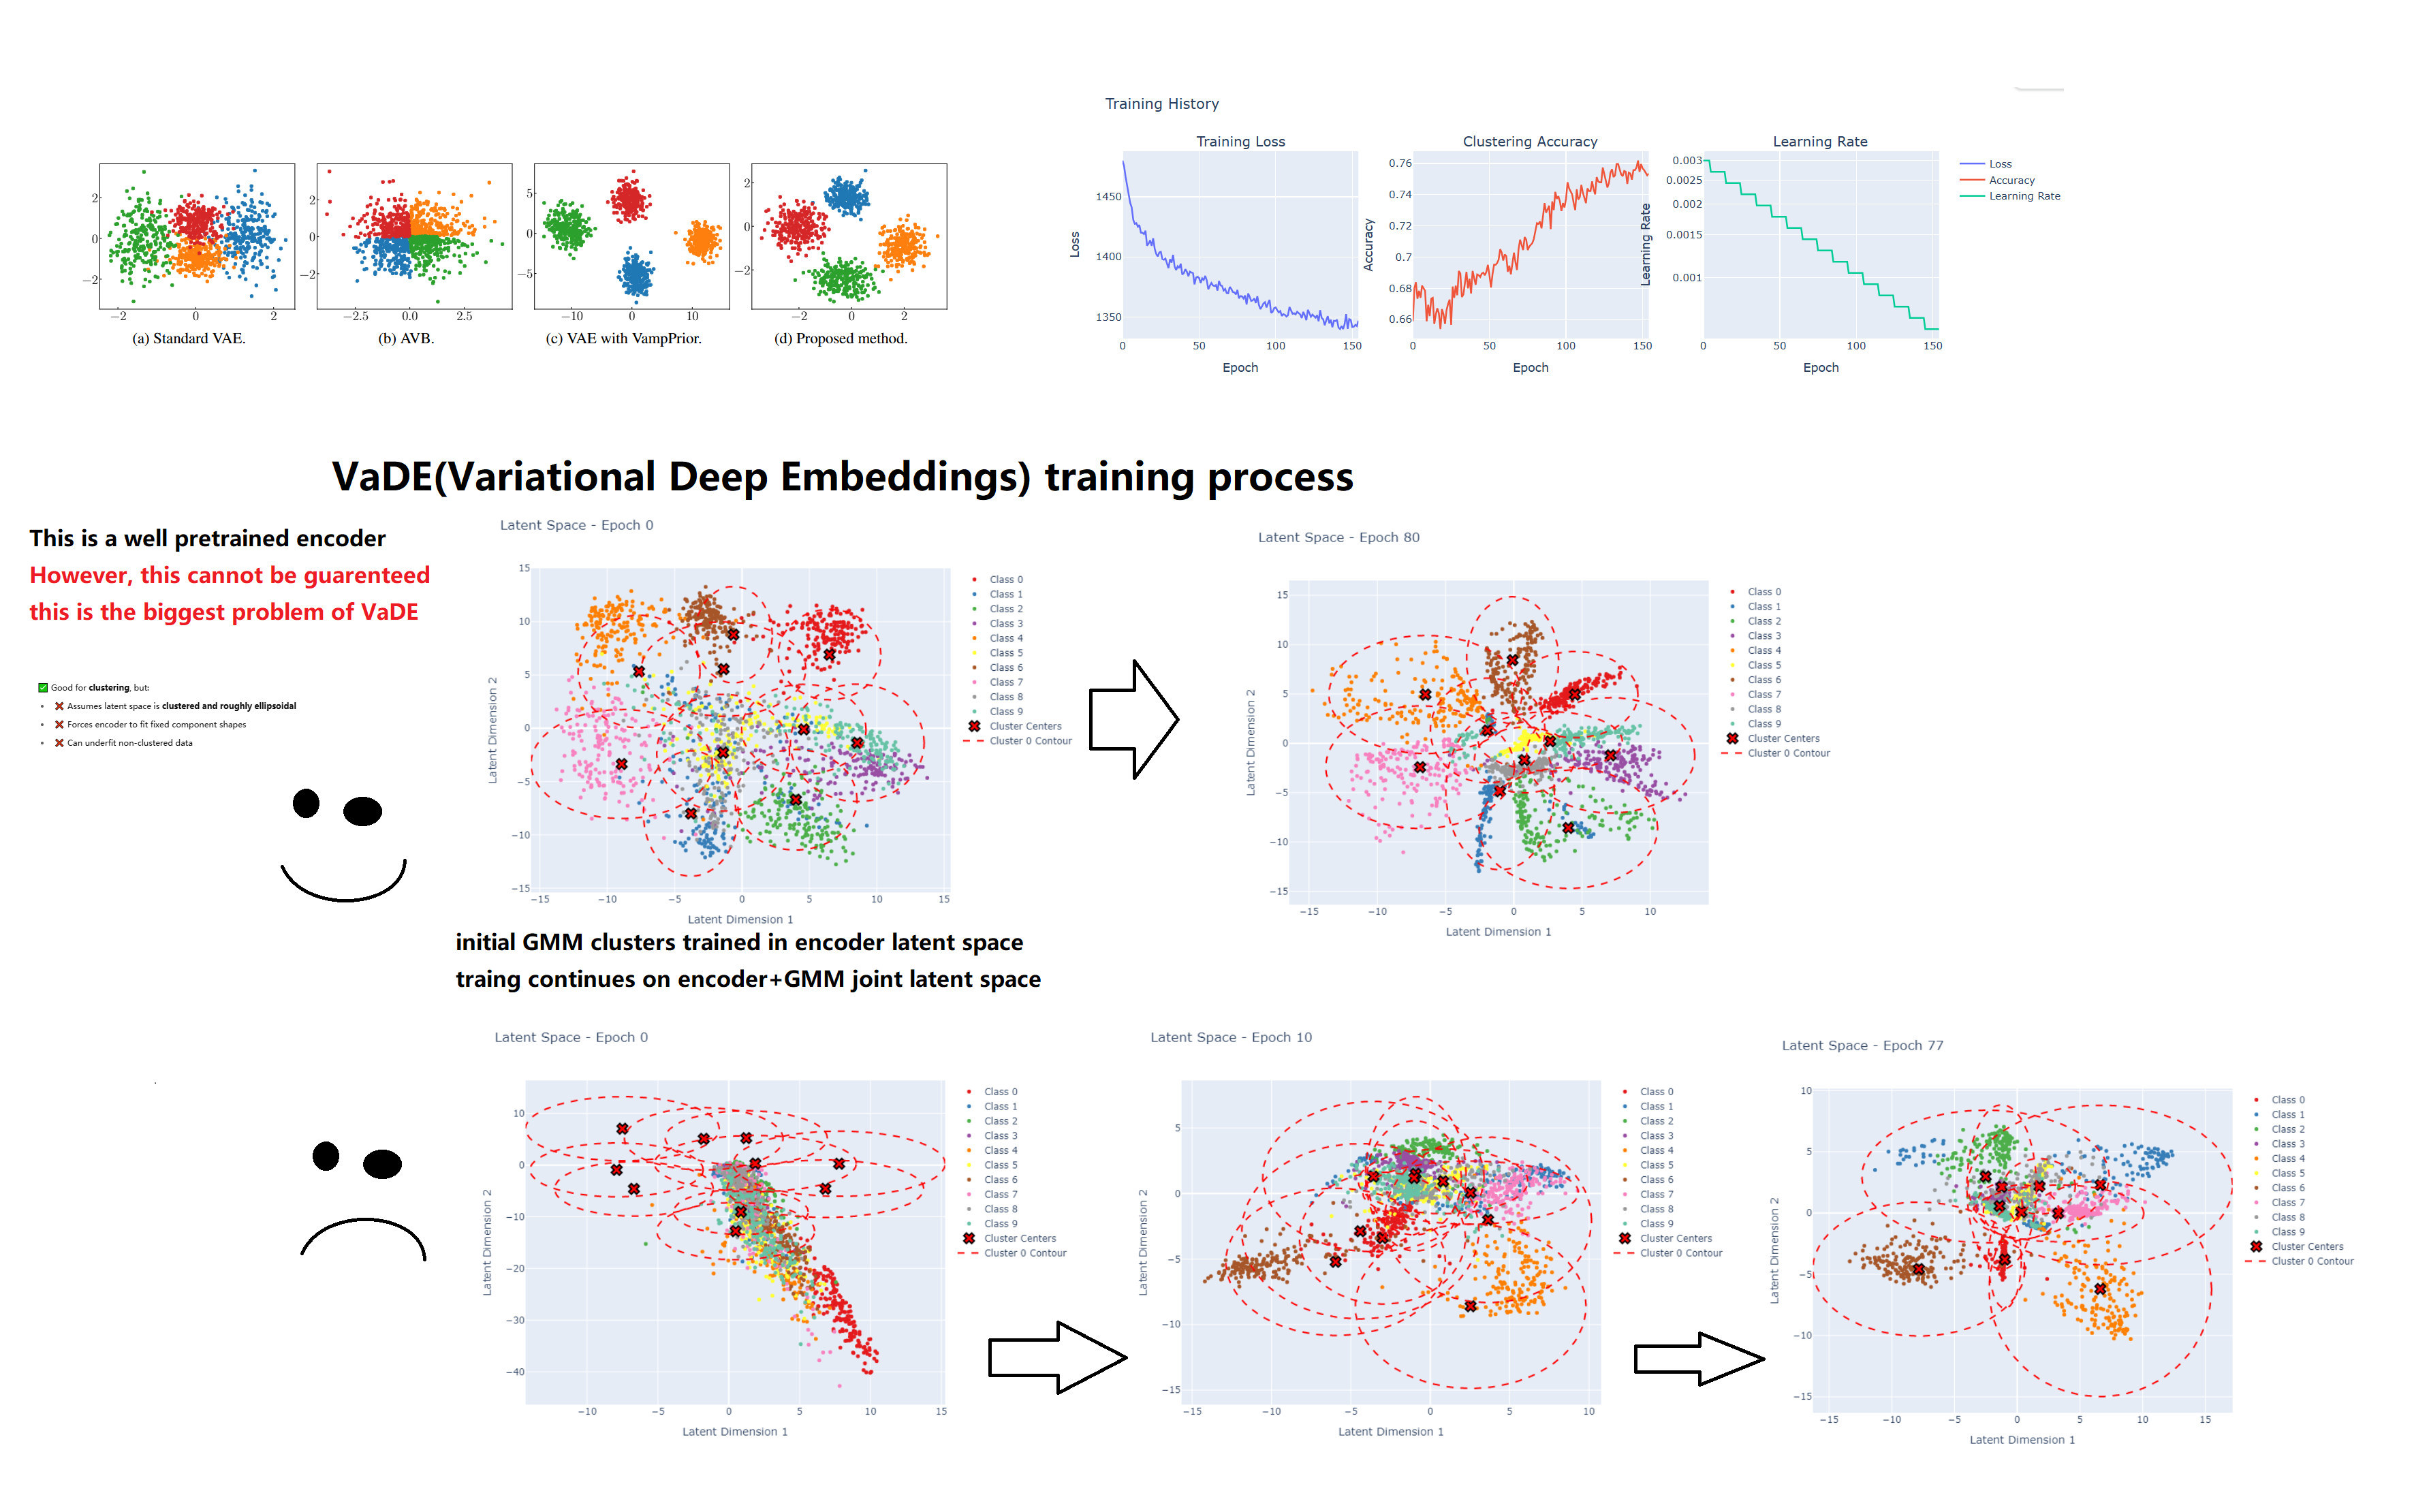

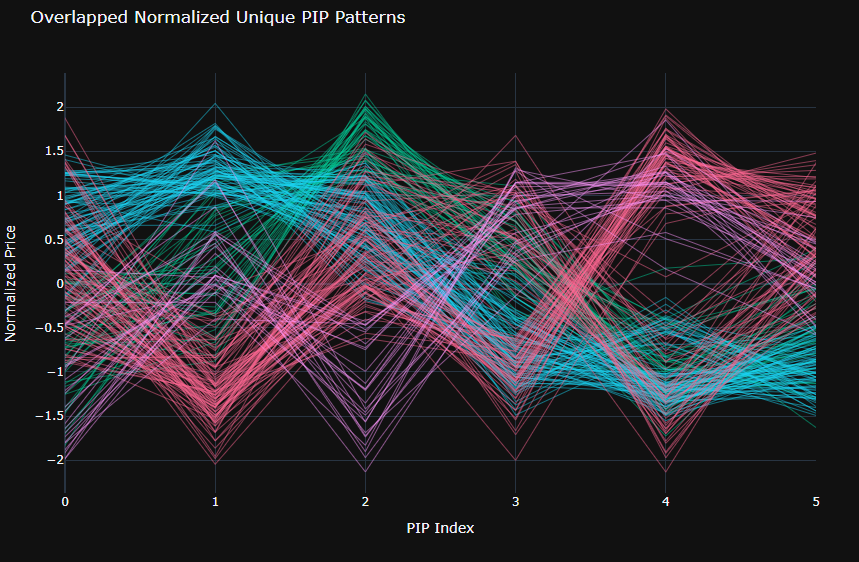

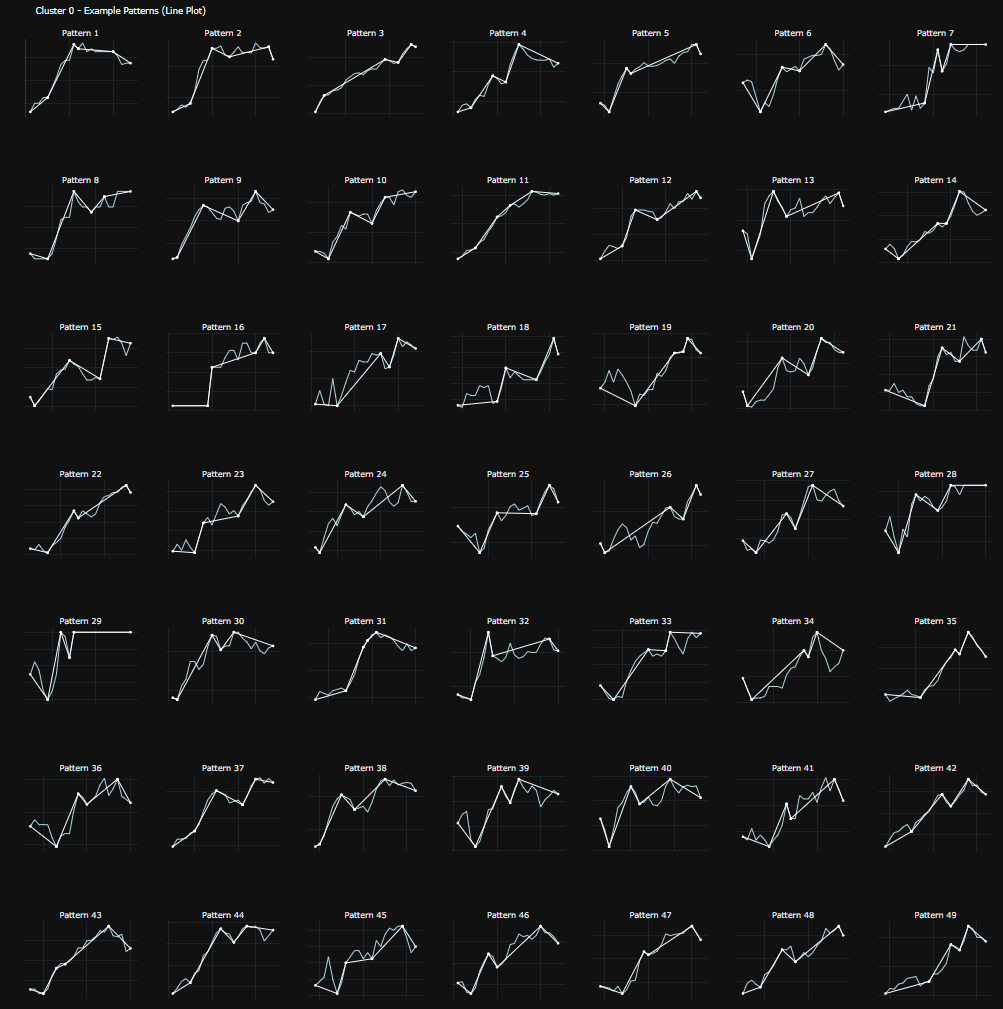

In [ ]:

from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from operator import mul
from functools import reduce
import copy
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
from typing import List


# dir = os.getcwd()
dir = os.path.dirname(__file__)


def main():
    data_path = os.path.join(dir, "data/bars.parquet")

    time_bar_dtype = {
        'time': 'int64',
        'open': 'float32',
        'high': 'float32',
        'low': 'float32',
        'close': 'float32',
        'volume': 'float32',
    }

    run_bar_dtype = {
        'time': 'int64',
        'timedelta': 'int32',
        'open': 'float32',
        'high': 'float32',
        'low': 'float32',
        'close': 'float32',
        'vwap': 'float32',
        'threshold': 'float32',
        'label_continuous': 'float32',
        'label_discrete': 'int32',
        'label_uniqueness': 'float32',
        'umap_x': 'float32',
        'umap_y': 'float32',
        'umap_z': 'float32',
    }

    input_dtype = np.dtype([(k, v) for k, v in time_bar_dtype.items()])
    output_dtype = np.dtype([(k, v) for k, v in run_bar_dtype.items()])

    time_bar = pd.read_parquet(data_path).reset_index(drop=True)
    input_array = time_bar.to_records(index=False).astype(input_dtype)
    input_bytes = input_array.tobytes()

    print(time_bar)
    print("Num bars:", input_array.shape[0])
    print("Bytes per record:", input_array.dtype.itemsize)

    from cpp import Pipeline  # type: ignore
    try:
        output_bytes = Pipeline.process_bars(input_bytes, input_array.shape[0])
    except Exception as e:
        import traceback
        traceback.print_exc()
        print("Caught exception:", str(e))

    vrun_bar = pd.DataFrame(np.frombuffer(output_bytes, dtype=output_dtype))
    # vrun_bar['return'] = np.log1p(vrun_bar['close'].pct_change().fillna(0))
    print(vrun_bar)

    from collections import deque
    lookback = 24
    bars_per_pip = 4
    n_pips = int(lookback/bars_per_pip)
    hold_period = int(lookback/2)

    # # Set parameters
    # n = 5000  # number of time steps
    # mu = 0.0  # drift
    # sigma = 1.0  # volatility (standard deviation)
    # dt = 1.0  # time step
    # np.random.seed(42)  # for reproducibility
    # dW = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt), size=n)
    # price = np.cumsum(dW) + 100  # start at arbitrary price like 100
    # price = price.astype(np.float32)

    price = ((time_bar['high'] + time_bar['low'])/2).to_numpy(dtype=np.float32)
    miner = PIPPatternMiner(n_pips, lookback, hold_period)
    miner.train(price)
    miner.predict()

    # import plotly.graph_objects as go
    # fig = go.Figure()
    # fig.add_trace(go.Scatter(y=df['close'], mode='lines+markers', showlegend=False))
    # for result in tqdm(results):
    #     fig.add_trace(go.Scatter(x=result[0], y=result[1], mode='lines', showlegend=False))
    # fig.show()


class PIPPatternMiner:
    """
    Perceptually Important Point (PIP) Pattern Miner that:
    1. Identifies PIP patterns in price data
    2. Clusters similar patterns
    3. Selects best performing patterns for trading signals
    4. Evaluates performance using Martin ratio
    """

    def __init__(self, n_pips: int, lookback: int, hold_period: int):
        """
        Initialize pattern miner with key parameters

        Parameters:
        -----------
        n_pips : int
            Number of pivot points to identify in each pattern
        lookback : int 
            Window size (in bars) for pattern detection
        hold_period : int
            Number of bars to hold positions after pattern detection
        """
        self._n_pips = n_pips
        self._lookback = lookback
        self._hold_period = hold_period
        self._dist_measure = 1  # 1 - Euclidean 2 - Perpendicular 3 - Vertical

        # Pattern storage
        self._unique_pip_patterns = []                      # Stores normalized PIP patterns
        # self._unique_pip_futures = []
        self._unique_pip_indices = []                       # Stores indices where patterns occur
        self._unique_pip_martins = []                       # Stores martins as label where patterns occur

        # Clusters
        self._num_clusters = 0
        self._pip_clusters_centers: List[List[float]] = []  # Stores cluster centroids
        self._pip_clusters_indexes: List[List[int]] = []    # Stores cluster assignments
        self._pip_clusters_martins: List[List[float]] = []  # Stores cluster labels

        # Performance metrics
        self._labels_mean: List[float] = []
        self._labels_max: List[float] = []
        self._labels_min: List[float] = []
        self._long_clusters = []
        self._short_clusters = []

        # Data storage
        self._data = np.array([])                           # Array of log closing prices

    def _find_pips(self, data: np.ndarray):
        """
        Find 'n_pips' perceptually important points (PIPs) from a 1D price data array.
        Returns:
            pips_x (list): x-coordinates (indices) of PIPs
            pips_y (list): y-coordinates (price values) of PIPs
        """

        # Start with the first and last points as initial PIPs
        pips_x = [0, len(data) - 1]        # Indices
        pips_y = [data[0], data[-1]]      # Prices

        # Iteratively add one PIP until we have n_pips
        for curr_point in range(2, self._n_pips):
            md = 0.0               # Maximum distance found so far
            md_i = -1              # Index of point with max distance
            insert_index = -1      # Where to insert this point in the list

            # Go through each segment defined by two existing PIPs
            for k in range(0, curr_point - 1):
                left_adj = k
                right_adj = k + 1

                # Compute line parameters between two PIPs
                time_diff = pips_x[right_adj] - pips_x[left_adj]
                price_diff = pips_y[right_adj] - pips_y[left_adj]
                slope = price_diff / time_diff
                intercept = pips_y[left_adj] - pips_x[left_adj] * slope

                # Evaluate points between left_adj and right_adj
                for i in range(pips_x[left_adj] + 1, pips_x[right_adj]):
                    d = 0.0
                    if self._dist_measure == 1:
                        # Euclidean distance to both endpoints
                        d = ((pips_x[left_adj] - i) ** 2 + (pips_y[left_adj] - data[i]) ** 2) ** 0.5
                        d += ((pips_x[right_adj] - i) ** 2 + (pips_y[right_adj] - data[i]) ** 2) ** 0.5
                    elif self._dist_measure == 2:
                        # Perpendicular distance from the line
                        d = abs((slope * i + intercept) - data[i]) / ((slope ** 2 + 1) ** 0.5)
                    else:
                        # Vertical distance from the line
                        d = abs((slope * i + intercept) - data[i])

                    # Update max distance if this point is farther
                    if d > md:
                        md = d
                        md_i = i
                        insert_index = right_adj

            # Insert the point with the maximum distance
            pips_x.insert(insert_index, md_i)
            pips_y.insert(insert_index, data[md_i])

        return pips_x, pips_y

    def _find_martin(self, data: np.ndarray) -> float:
        """
        Compute the Martin ratio from a price series using only NumPy.
        Equivalent to _get_martin(), which expects log-returns.

        Martin Ratio = Total Log Return / Ulcer Index
        """
        if len(data) < 2:
            return 0.0

        # Log returns
        rets = np.diff(data)
        total_return = np.sum(rets)
        short = False

        # If return is negative, treat as short position
        if total_return < 0.0:
            rets *= -1
            total_return *= -1
            short = True

        # Reconstruct equity curve
        csum = np.cumsum(rets)
        eq = np.exp(csum)

        # Compute drawdown and Ulcer Index
        running_max = np.maximum.accumulate(eq)
        drawdown = (eq / running_max) - 1.0
        ulcer_index = np.sqrt(np.mean(drawdown ** 2))

        min_ulcer_index = max(1e-4, total_return * 0.05)  # ensure martin cannot exceed N* total returns
        if ulcer_index < min_ulcer_index:
            ulcer_index = min_ulcer_index

        martin = total_return / ulcer_index
        return -martin if short else martin

    def _find_unique_patterns(self):
        """Identify all unique PIP patterns in the data"""
        self._unique_pip_indices.clear()
        self._unique_pip_patterns.clear()
        self._unique_pip_martins.clear()

        # Track last pattern to avoid duplicates
        last_pips_x = [0] * self._n_pips

        assert isinstance(self._data, np.ndarray)

        # Slide window through data
        for i in tqdm(range(self._lookback - 1, len(self._data) - self._hold_period)):
            if (i % 4) != 0:
                continue
            
            start_i = i - self._lookback + 1
            window_lookback = self._data[start_i: i + 1]
            window_hold = self._data[i: i + self._hold_period]

            # Find PIPs in current window
            pips_x, pips_y = self._find_pips(window_lookback)
            pips_x = [j + start_i for j in pips_x]  # Convert to global indices
            # pips_y = np.concatenate([pips_y, window_hold])

            # Check if internal PIPs are same as last pattern (avoid duplicates)
            # https://link.springer.com/chapter/10.1007/11539506_146
            # only check index for trivial matches
            # conservative, as it still allow identical but shifted pattern to pass
            # to have strong filtering effect, lookback cannot be too large
            same = True
            for j in range(1, self._n_pips - 1):  # discard ~50%
                if pips_x[j] != last_pips_x[j]:
                    same = False
                    break

            if not same:
                # Normalize pattern by z-scoring
                pips_y = list((np.array(pips_y) - np.mean(pips_y)) / (np.std(pips_y) + 1e-8))
                self._unique_pip_indices.append(i)
                self._unique_pip_patterns.append(pips_y)
                # self._unique_pip_futures.append(pips_y)
                self._unique_pip_martins.append(self._find_martin(window_hold))

            last_pips_x = pips_x

    def _kmeans_cluster_patterns(self):
        """
        Cluster PIP patterns using k-means++
        """
        # Initialize centers using k-means++ algorithm
        initial_centers = kmeans_plusplus_initializer(self._unique_pip_patterns, self._num_clusters).initialize()

        # Perform k-means clustering
        kmeans_instance = kmeans(self._unique_pip_patterns, initial_centers)
        kmeans_instance.process()

        # Store results
        self._pip_clusters_centers = kmeans_instance.get_centers()  # type: ignore
        self._pip_clusters_indexes = kmeans_instance.get_clusters()  # type: ignore

    def _get_cluster_performance(self):
        self._labels_mean = []
        self._labels_max = []
        self._labels_min = []
        for i in range(self._num_clusters):
            martins: List[float] = [self._unique_pip_martins[idx] for idx in self._pip_clusters_indexes[i]]
            self._pip_clusters_martins.append(martins)
            self._labels_mean.append(float(np.mean(martins)))
            self._labels_max.append(float(np.max(martins)))
            self._labels_min.append(float(np.min(martins)))

        long_to_short = np.argsort(self._labels_mean)[::-1]  # descending order (high → low)
        good_clusters = int(self._num_clusters/8)
        self._long_clusters = long_to_short[:good_clusters]
        self._short_clusters = long_to_short[-good_clusters:]
        print(f"best patterns from long to short: {long_to_short}:{[float(self._labels_mean[i]) for i in long_to_short]}")

    def plot_unique_samples(self):
        import plotly.graph_objects as go

        patterns = self._unique_pip_patterns
        print(f'Plotting {len(patterns)} unique patterns')

        fig = go.Figure()
        for i, pattern in enumerate(patterns):
            fig.add_trace(go.Scatter(
                x=list(range(len(pattern))),
                y=pattern,
                mode="lines",
                line=dict(width=1),
                showlegend=False,
                opacity=0.5
            ))

        fig.update_layout(
            title="Overlapped Normalized Unique PIP Patterns",
            xaxis_title="PIP Index",
            yaxis_title="Normalized Price",
            template="plotly_dark",
            height=600
        )

        fig.show()

    def plot_clusters(self):
        import plotly.graph_objects as go
        import plotly.express as px

        cluster_colors = px.colors.qualitative.Plotly

        for clusters in [self._long_clusters, self._short_clusters]:
            fig = go.Figure()
            for i in clusters:
                color = cluster_colors[i % len(cluster_colors)]
                for index in self._pip_clusters_indexes[i]:
                    pattern = self._unique_pip_patterns[index]
                    # pattern += self._unique_pip_futures[index]

                    fig.add_trace(go.Scatter(
                        x=list(range(len(pattern))),
                        y=pattern,
                        mode="lines",
                        line=dict(width=1, color=color),
                        showlegend=False,
                        opacity=0.5
                    ))

            fig.update_layout(
                title="Overlapped Normalized Unique PIP Patterns",
                xaxis_title="PIP Index",
                yaxis_title="Normalized Price",
                template="plotly_dark",
                height=600
            )

            fig.show()

    def plot_cluster_samples(self, cluster_i: int, grid_size: int = 5):
        """
        Plot example PIP patterns from a specific cluster using only internal log-price data.

        Parameters:
        -----------
        cluster_i : int
            Cluster index to visualize.
        grid_size : int
            Number of rows/columns in the subplot grid.
        """
        import plotly.graph_objects as go
        from plotly.subplots import make_subplots

        total_plots = grid_size * grid_size
        fig = make_subplots(
            rows=grid_size, cols=grid_size,
            subplot_titles=[f"Pattern {i + 1}" for i in range(total_plots)],
            shared_xaxes=False, shared_yaxes=False
        )

        for i in range(total_plots):
            if i >= len(self._pip_clusters_indexes[cluster_i]):
                break

            pat_i = self._unique_pip_indices[self._pip_clusters_indexes[cluster_i][i]]
            start_i = pat_i - self._lookback + 1
            end_i = pat_i + 1

            if start_i < 0 or end_i > len(self._data):
                continue  # skip if out of bounds

            data_slice = self._data[start_i:end_i]
            time_idx = list(range(start_i, end_i))

            # Find PIPs (vertical distance by default)
            plot_pip_x, plot_pip_y = self._find_pips(data_slice)
            plot_pip_x = [time_idx[x] for x in plot_pip_x]

            row = i // grid_size + 1
            col = i % grid_size + 1

            # Add raw price trace
            fig.add_trace(
                go.Scatter(
                    x=time_idx,
                    y=data_slice,
                    mode="lines",
                    line=dict(color='lightblue', width=2),
                    showlegend=False
                ),
                row=row, col=col
            )

            # Add PIP lines
            for j in range(self._n_pips - 1):
                fig.add_trace(
                    go.Scatter(
                        x=[plot_pip_x[j], plot_pip_x[j + 1]],
                        y=[plot_pip_y[j], plot_pip_y[j + 1]],
                        mode="lines+markers",
                        line=dict(color='white', width=2),
                        marker=dict(color='white', size=5),
                        showlegend=False
                    ),
                    row=row, col=col
                )

        fig.update_layout(
            height=grid_size * 300,
            width=grid_size * 300,
            title_text=f"Cluster {cluster_i} - Example Patterns (Line Plot)",
            template="plotly_dark",
            margin=dict(t=100)
        )

        fig.update_xaxes(showticklabels=False)
        fig.update_yaxes(showticklabels=False)

        fig.show()


    def plot_umap_3D(self):
        import umap
        import plotly.graph_objects as go
        import plotly.express as px
        import numpy as np

        _unique_pip_clusters = np.zeros(len(self._unique_pip_patterns))

        for idx, clusters in enumerate(self._pip_clusters_indexes):
            for i in clusters:
                _unique_pip_clusters[i] = idx

        X = pd.DataFrame(self._unique_pip_patterns)
        # y = pd.Series(self._unique_pip_martins)
        y = pd.Series(_unique_pip_clusters)
        
        # # Automatically compute 10 even percentiles for binning
        # percentile_edges = np.percentile(y, np.linspace(0, 100, 11))  # 11 edges → 10 bins
        # percentile_centers = [(percentile_edges[i] + percentile_edges[i + 1]) / 2 for i in range(10)]
        # 
        # def bin_to_centers(series, edges, centers):
        #     return pd.cut(series, bins=edges, labels=centers, include_lowest=True).astype(float)
        # 
        # y = bin_to_centers(y, percentile_edges, percentile_centers)

        n_neighbors = min(15, X.shape[0] - 1)

        algo_umap = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=0.1)
        X_3d = np.array(algo_umap.fit_transform(X))

        classes = np.sort(np.unique(y))[::-1]  # sort from large(red) to small(blue)
        print(f'Classes: {classes}')

        # RdBu continuous colorscale
        colorscale = px.colors.diverging.RdBu
        n_colors = len(colorscale)

        fig = go.Figure()

        for i, cls in enumerate(classes):
            idx = y == cls
            # Map class index to a color in RdBu colorscale
            color_idx = int(i / (len(classes) - 1) * (n_colors - 1)) if len(classes) > 1 else 0
            color = colorscale[color_idx]

            fig.add_trace(go.Scatter(
                x=X_3d[idx, 0], y=X_3d[idx, 1],# z=X_3d[idx, 2],
                mode='markers',
                name=f'Class {cls}',
                marker=dict(
                    size=4,
                    color=color,
                    opacity=1.0,
                )
            ))

        fig.show()

    def train_VAE(self):
        from VAE import VAE
        import numpy as np
        import plotly.graph_objects as go
        from scipy.stats import gaussian_kde
        import umap
        from sklearn.mixture import GaussianMixture

        # Step 1: Prepare data
        X = np.array(self._unique_pip_patterns, dtype=np.float32)
        # Apply exponential weights to columns (features): heavier on recent points
        num_features = X.shape[1]
        exp_weights = np.linspace(1.0, 10.0, num_features, dtype=np.float32)  # or use np.geomspace(1.0, 2.0, num=num_features)

        X_weighted = X * exp_weights  # shape: (N, D), element-wise weighting
        
        vae = VAE(input_dim=X_weighted.shape[1], hidden_dim=64, latent_dim=8, epochs=200)
        vae.train_model(X_weighted)
        latent_means = vae.encode_data(X_weighted)  # (N, latent_dim)

        # Step 2: UMAP to 3D
        n_neighbors = min(15, X_weighted.shape[0] - 1)
        algo_umap = umap.UMAP(n_components=3, n_neighbors=n_neighbors, min_dist=0.1)
        X_3d = algo_umap.fit_transform(latent_means)  # (N, 3)

        # Step 3: GMM Clustering in Latent Space
        self._num_clusters = 40  # change as needed
        gmm = GaussianMixture(n_components=self._num_clusters, covariance_type='full', random_state=42)
        gmm.fit(latent_means)
        cluster_labels = gmm.predict(latent_means)

        self._pip_clusters_centers = gmm.means_  # shape: (n_components, latent_dim)
        self._pip_clusters_indexes = [
            np.where(cluster_labels == i)[0].tolist()
            for i in range(self._num_clusters)
        ]

        # Step 4: 3D KDE
        kde = gaussian_kde(X_3d.T)
        grid_size = 50
        x = np.linspace(X_3d[:, 0].min(), X_3d[:, 0].max(), grid_size)
        y = np.linspace(X_3d[:, 1].min(), X_3d[:, 1].max(), grid_size)
        z = np.linspace(X_3d[:, 2].min(), X_3d[:, 2].max(), grid_size)
        Xg, Yg, Zg = np.meshgrid(x, y, z, indexing="ij")
        coords = np.vstack([Xg.ravel(), Yg.ravel(), Zg.ravel()])
        density = kde(coords).reshape(grid_size, grid_size, grid_size)

        # Step 5: Create Plot
        fig = go.Figure()

        # Volumetric KDE
        fig.add_trace(go.Volume(
            x=Xg.flatten(),
            y=Yg.flatten(),
            z=Zg.flatten(),
            value=density.flatten(),
            isomin=density.min(),
            isomax=density.max(),
            opacity=0.05,
            surface_count=15,
            colorscale='Viridis',
            showscale=False
        ))

        # Clustered points in 3D
        fig.add_trace(go.Scatter3d(
            x=X_3d[:, 0],
            y=X_3d[:, 1],
            z=X_3d[:, 2],
            mode='markers',
            marker=dict(
                size=4,
                color=cluster_labels,  # categorical color
                colorscale='Rainbow',
                opacity=0.9,
                colorbar=dict(title='Cluster')
            ),
            text=[f"Cluster {label}" for label in cluster_labels],
            name='Clustered Samples'
        ))

        fig.update_layout(
            title="3D Volumetric KDE with GMM Clustered Latent Points",
            scene=dict(
                xaxis_title='UMAP 1',
                yaxis_title='UMAP 2',
                zaxis_title='UMAP 3'
            )
        )
        fig.show()



    def train(self, arr: np.ndarray):
        """
        Train pattern miner on price data

        Parameters:
        -----------
        arr : np.array
            Array of log prices
        n_reps : int
            Number of permutation tests to run (-1 for none)
        """
        data = arr.astype(np.float32)  # work on log price for pattern recognition
        self._data = data[:10000]
        self._test = data[10000:20000]
        # self._returns = np.append(np.diff(self._data)[1:], np.nan)

        # Step 1: Find all unique PIP patterns
        self._find_unique_patterns()
        # self.plot_unique_samples()

        self.train_VAE()
        
        # # Step 2: Cluster patterns using silhouette method for optimal k
        # search_instance = silhouette_ksearch(self._unique_pip_patterns, 15, 40, algorithm=silhouette_ksearch_type.KMEANS).process()
        # self._num_clusters = search_instance.get_amount()
        # print(f'Got {self._num_clusters} clusters (Silhouette Ksearch)')
        # 
        # # Step 3: Perform k-means clustering
        # self._kmeans_cluster_patterns()

        # Step 4: Analyze clusters performance
        self._get_cluster_performance()

        # self.plot_umap_3D()

        self.plot_clusters()

        self.plot_cluster_samples(0,7)
        self.plot_cluster_samples(4,7)
        self.plot_cluster_samples(7,7)
        self.plot_cluster_samples(15,7)
        self.plot_cluster_samples(19,7)


    def predict(self):
        """
        Predict trading signal (long/short/neutral) for new PIP pattern
        """
        
        hold = int(self._hold_period/2)
        
        signals = np.zeros(len(self._test), dtype=int)
        for i in tqdm(range(self._lookback - 1, len(self._test) - self._hold_period)):
            start_i = i - self._lookback + 1
            window_lookback = self._test[start_i: i + 1]

            pips_x, pips_y = self._find_pips(window_lookback)
            pips_x = [j + start_i for j in pips_x]  # Convert to global indices

            norm_y = (np.array(pips_y) - np.mean(pips_y)) / (np.std(pips_y) + 1e-8)

            # Find closest cluster center
            best_dist = 1.e30
            best_clust = -1
            for clust_i in range(len(self._pip_clusters_centers)):
                center = np.array(self._pip_clusters_centers[clust_i])
                dist = np.linalg.norm(norm_y-center)
                if dist < best_dist:
                    best_dist = dist
                    best_clust = clust_i
                    
            # Return appropriate signal
            if best_clust in self._long_clusters:
                signals[i: i + hold] = 1
            elif best_clust in self._short_clusters:
                signals[i: i + hold] = -1

        cum_long = 0
        cum_short = 0
        cum_long_list = []
        cum_short_list = []
        ret = np.append(np.diff(self._test), 0.0)
        direction = 0
        for i, signal in enumerate(signals):
            if signal != 0:
                direction = signal
                
            if direction == 1:
                cum_long += ret[i]
            elif direction == -1:
                cum_short += -ret[i]
            cum_long_list.append(cum_long)
            cum_short_list.append(cum_short)

        cum_total_list = cum_long_list + cum_short_list

        import plotly.graph_objects as go
        fig = go.Figure()

        fig.add_trace(go.Scatter(y=cum_long_list))
        fig.add_trace(go.Scatter(y=cum_short_list))
        # fig.add_trace(go.Scatter(y=cum_total_list))
        fig.show()

        fig = go.Figure()
        colors = np.where(signals == 1, 'red', np.where(signals == -1, 'green', 'gray'))
        l = 5000
        fig = go.Figure(go.Scatter(
            x=np.arange(l),
            y=self._test[:l],
            mode='markers',
            marker=dict(color=colors, size=6),
            name='Signal Colored'
        ))
        fig.show()

if __name__ == "__main__":
    main()
